# Has the weather an impact on the spread of the coronavirus?

<img src="img/coronavirus-weather-hero.jpg">

With more than 775 748 peoples infected and 37109 deaths (03/30/2020) and with a significative decrease of usual human activity, the COVID-19 will be remembered as a sad part of mankind's history. I, like many others, am trying to keep doing what I love to do and avoid get crazy thinking about the impact of this crisis in my family and people around the World. I am not a politician, I don't have any kind of power, I'm not a doctor or nurse, and even when I have some ideas and hypotheses about what could be done to get through this crisis (as any other person), I only have my family and potentially my group of 50 friends in Facebook to share it. But, at the same time, I feel that I need to do something else, and for that reason I began this project as a modest contribution of what I think could be some interesting open questions about the COVID-19.

These are the questions:
1. Is there some relationship between the temperature and the spread of the virus? In such a case, what is the minimum temperature that help to slow down it spread?
2. Has the humidity some kind of impact on the spread of the virus?
3. What happens with the virus at different atmospheric pressures?
   
This project is structured as follows:
1. [Data Collection and Cleaning](#data_collection_and_cleaning)
    1. [Cities Selection](#cities_selection)
        1. [Cities in countries with more infections.](#cities_in_countries_with_more_infections)
        2. [Cities in Coldest Countries.](#coldest_countries)
        3. [Cities in Hottest Countries.](#hottest_countries)
    2. [Weather Data](#weather_data)
        1. [Merging the weather and the COVID-19 datasets.](#merging_weather_COVID_datasets)
2. [Weather and New Infections.](#weather_and_new_infections)
    1. [Coronavirus vs Temperature.](#coronavirus_vs_temperature)
    2. [Coronavirus vs Humidity.](#coronavirus_vs_humidity)
    3. [Coronavirus vs Pressure.](#coronavirus_vs_pressure)
3. [Conclusions and Remarks.](#conclusions_and_remarks)

## Data Collection and Cleaning
<a id='data_collection_and_cleaning'></a>

The above questions are related to a more general motivation [proposed at Kaggle](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/tasks?taskId=62). One of the main dataset that I am going to use in this projects was also obtained from Kaggle ("[covid_19_data.csv](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv)") and relates the total number of confirmed, deaths and recovered cases per day, `Province/State` and `Country/Region`.        

In [72]:
# Load libraries
import pandas as pd
import numpy as np
# Use the "glob" module to extract pathnames matching a specified pattern
import glob
import calendar
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Statistics
from scipy import stats

The COVID-19 dataset is composed by 8 variables which description could be found [here](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset). 

In [76]:
# Load the "covid_19_data" dataset 
covid_2019=pd.read_csv("novel-corona-virus-2019-dataset/covid_19_data.csv")
covid_2019.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


As we can see in the following descriptive data frame, this data is composed of 11614 observations with 119827 infections, 14681 deaths and 63612 recovered patients around the world. An important piece of information is that the variables `Confirmed`, `Deaths` and `Recovered` are cumulative and for that reason, at this point, we can't say anything for example about the mean number of new cases by day.

In [80]:
# Describes the continuous variables
covid_2019.describe()

,SNo,Confirmed,Deaths,Recovered
count,11614.000000,11614.000000,11614.000000,11614.000000
mean,5807.500000,1175.025831,51.019373,320.180902
std,3352.817348,7096.206263,490.706034,3145.856598
min,1.000000,0.000000,0.000000,0.000000
25%,2904.250000,4.000000,0.000000,0.000000
50%,5807.500000,39.000000,0.000000,0.000000
75%,8710.750000,266.000000,2.000000,17.000000
max,11614.000000,119827.000000,14681.000000,63612.000000


Before going forward, it's important to transform the variables to the correct format.

In [3]:
# Actual data types
covid_2019.dtypes

SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

In [132]:
## Transform the data type to the correct format
# 'Last Update' and 'ObservationDate' to datetime
covid_2019['Last Update']=pd.to_datetime(covid_2019['Last Update'])
covid_2019['ObservationDate']=pd.to_datetime(covid_2019['ObservationDate'])
# 'Confirmed','Deaths','Recovered' to int
covid_2019[['Confirmed','Deaths','Recovered']]=covid_2019[['Confirmed','Deaths','Recovered']].astype('int')
# 'Province/State' and 'Country/Region' to category
covid_2019[['Province/State','Country/Region']]=covid_2019[['Province/State','Country/Region']].astype('category')
covid_2019.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State           category
Country/Region           category
Last Update        datetime64[ns]
Confirmed                   int64
Deaths                      int64
Recovered                   int64
dtype: object

In [133]:
print('Some general facts about our data:')
print('=> The first day reported in our data was {}.'.format(min(covid_2019['Last Update'])))
print('=> While the last day included is {}.'.format(max(covid_2019['Last Update'])))
print('=> Our data resume the information of the coronavirus spread in {}'.format(max(covid_2019['Last Update']) - min(covid_2019['Last Update'])))
print('=> During these days, a total of {} Province/States had reported at least one case of coronavirus.'.format(len(covid_2019['Province/State'].unique())))
print('=> These Province/States are distributed in {} countries or regions.'.format(len(covid_2019['Country/Region'].unique())))

Some general facts about our data:
=> The first day reported in our data was 2020-01-22 17:00:00.
=> While the last day included is 2020-04-03 22:52:45.
=> Our data resume the information of the coronavirus spread in 72 days 05:52:45
=> During these days, a total of 295 Province/States had reported at least one case of coronavirus.
=> These Province/States are distributed in 216 countries or regions.


### Cities Selection
<a id='cities_selection'></a>

For this study I considered the weather in the last 4 months (December 1 to March 29) of 9 differents cities. The selection criterion was:
* Include the most infected city of the 3 countries with more cases. At 2020-04-03 these countries were US, Italy, and Spain, and the cities were "New York" (US), the region of "Lombardia" in Italy (in this case we selected Milan, which is the capital of Lombardia), and Madrid (Spain) (see details in the subsection [Cities in Countries with more Infections](#cities_in_countries_with_more_infections)).
* Include the city with a greater number of cases in the 3 coldest countries. The list with the coldest countries in the World was obtained from [here](https://www.swedishnomad.com/coldest-countries-in-the-world/) taking into account the average yearly temperature.  
    * The results show that the coldest countries with more cases are "Austria", "Sweden", and Canada with 11524, 6131 and 6101 cases respectively. For these countries the most afected cities are Vienna (Austria's capital), Stockholm (Sweden's capital), and Quebec in Canada. For details, see the subsection [Cities in Coldest-Countries](#coldest_countries). 
* Include the city with a greater number of cases in the 3 hottest countries. A list with the 15 hottest countries given the average yearly temperature was obtained from [here](https://www.swedishnomad.com/hottest-countries-in-the-world/). 
    * Given these selection parameters, I obtained that the hottest 3 countries with the greatest number of cases are United Arab Emirates, Qatar, and Burkina Faso with 1264, 1075 and 302 cases respectively. Unfortunately, I can't found free weather information about Burkina Faso, and as consequence I pick the next country in the list, which is Senegal with 207 cases. The weather of the cities with more cases of these 3 countries (Dubai (United Arab Emirates), Doha (Qatar), Dakar (Senegal)) were selected for this analysis (see details in the subsection [Cities in Hottest-Countries](#hottest_countries)).


> Unfortunately, it was very difficult for me to find accurate information about the weather by country/cities in the last 4 months. All the webpages sell this information (and is very expensive by the way), so, I collected and curated manually this data. If anybody has or knows where to obtain this kind of data easily, please, share this information. If you want to use this information, it is available[here](https://github.com/Yasel-Garces/The-impact-of-weather-in-the-coronavirus-spread).

#### Cities in Countries with more Infections.
<a id='cities_in_countries_with_more_infections'></a>

In [134]:
# Extract the data of the last day
covid_2019_lastDay=covid_2019.loc[covid_2019['ObservationDate']==max(covid_2019['ObservationDate']),:]
covid_2019_lastDay.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
11299,11300,2020-04-03,NaN,Afghanistan,2020-04-03 22:52:45,281,6,10
11300,11301,2020-04-03,NaN,Albania,2020-04-03 22:52:45,304,17,89
11301,11302,2020-04-03,NaN,Algeria,2020-04-03 22:52:45,1171,105,62
11302,11303,2020-04-03,NaN,Andorra,2020-04-03 22:52:45,439,16,16
11303,11304,2020-04-03,NaN,Angola,2020-04-03 22:52:45,8,2,1


In [135]:
# Compute the total number of cases by country
cases_by_countries=covid_2019_lastDay.pivot_table(index=['Country/Region'],
                                                  values='Confirmed',
                                                  aggfunc='sum').sort_values(by='Confirmed',
                                                                             ascending=False)
print('The countries with more cases are:\n {}'.format(cases_by_countries.head()))

The countries with more cases are:
                 Confirmed
Country/Region           
US                 275586
Italy              119827
Spain              119199
Germany             91159
Mainland China      81623


In [136]:
# Select the city with more cases in the 3 countries with more cases.
countries=['US', 'Italy','Spain']
function = lambda country: covid_2019_lastDay.loc[covid_2019_lastDay['Country/Region']==country,:].sort_values(by='Confirmed',
                                                                             ascending=False).iloc[0,[2,5]]
# Stores the results in a dictionary
result={country: list(function(country)) for country in countries}
print('The cities with more cases for each of the top countries are:\n {}'.format(pd.DataFrame(result)))

The cities with more cases for each of the top countries are:
          US     Italy     Spain
0  New York       NaN       NaN
1    102987  119827.0  119199.0


We can see here something unexpected (wasn't obtained any city for Italy or Spain). Let's see what happened:

In [137]:
# Slice the dataset to show only the information relative to Italy 
covid_2019.loc[covid_2019['Country/Region']=='Italy',:].sort_values(by='Confirmed',
                                                                             ascending=False).head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
11379,11380,2020-04-03,NaN,Italy,2020-04-03 22:52:45,119827,14681,19758
11064,11065,2020-04-02,NaN,Italy,2020-04-02 23:32:01,115242,13915,18278
10751,10752,2020-04-01,NaN,Italy,2020-04-01 22:04:58,110574,13155,16847
10438,10439,2020-03-31,NaN,Italy,2020-03-31 23:49:27,105792,12428,15729
10125,10126,2020-03-30,NaN,Italy,2020-03-30 22:58:55,101739,11591,14620


The problem seems to be clear! Our data doesn't contain the information of Italy or Spain segmented by regions or provinces (note that only exists one record per day). Fortunately, in the case of Italy, this inconvenience can be overcome using another available [dataset in Kaggle that contain specific information about Italy](https://www.kaggle.com/sudalairajkumar/covid19-in-italy#covid19_italy_region.csv). Therefore, I decided to drop all the information relative to Italy from the `covid_2019` dataset and include the new information available in the Italy dataset.

In [138]:
# Drop all the information relative  to Italy from "covid_2019"
covid_2019=covid_2019.loc[covid_2019['Country/Region']!='Italy',:]
# Check that the information was droped
covid_2019.loc[covid_2019['Country/Region']=='Italy',:]

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered


In [139]:
# Load the new dataframe with the information about Italy
italy=pd.read_csv("novel-corona-virus-2019-dataset/covid19_italy_region.csv")
# Print the columns of this data frame
print(italy.columns)

Index(['SNo', 'Date', 'Country', 'RegionCode', 'RegionName', 'Latitude',
       'Longitude', 'HospitalizedPatients', 'IntensiveCarePatients',
       'TotalHospitalizedPatients', 'HomeConfinement', 'CurrentPositiveCases',
       'NewPositiveCases', 'Recovered', 'Deaths', 'TotalPositiveCases',
       'TestsPerformed'],
      dtype='object')


If we look at the columns of the `italy` data frame, it's easy to realize that we only need to consider the next variables to include in our `covid_19` data frame: `Sno`, `Country`, `Date`, `Recovered`, `Deaths`, `TotalPositiveCases`.

In [140]:
# Create a new dataframe for Italy with only the necesary variables (listed above)
italy=italy[['SNo','Date','RegionName','Country','Date','TotalPositiveCases','Deaths','Recovered']]
# Name the columns as in covid_19
italy.columns=['SNo','ObservationDate','Province/State','Country/Region','Last Update',
               'Confirmed','Deaths','Recovered']

In [141]:
# Concat the two dataframes
covid_2019=pd.concat([covid_2019,italy])
# Rename ITA for Italy
covid_2019['Country/Region'].replace(to_replace='ITA',value='Italy',inplace=True)
covid_2019.loc[covid_2019['Country/Region']=='Italy',:].head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,0,2020-02-24T18:00:00,Abruzzo,Italy,2020-02-24T18:00:00,0,0,0
1,1,2020-02-24T18:00:00,Basilicata,Italy,2020-02-24T18:00:00,0,0,0
2,2,2020-02-24T18:00:00,P.A. Bolzano,Italy,2020-02-24T18:00:00,0,0,0
3,3,2020-02-24T18:00:00,Calabria,Italy,2020-02-24T18:00:00,0,0,0
4,4,2020-02-24T18:00:00,Campania,Italy,2020-02-24T18:00:00,0,0,0


I don't found detailed information about the number of cases in Spain by region, but, we know that the greatest number of cases are in Madrid, so, I'm going to pick the information about the weather in Madrid for this analysis.      
Finally, the functions `transform_dtypes` and `cases_country_city` available in the `functions.py` script runs all the steps that we did earlier in [this section](#cities_in_countries_with_more_infections). The results shows that at this moment New York is US's city with more cases ($\approx 102987$), while the region of Lombardia in Italy has $\approx 47520$ cases.

In [142]:
from functions import transform_dtypes, cases_country_city
# Transform data types
covid_2019=transform_dtypes(covid_2019)
# Extract the information about the cities with more cases
_ , cities=cases_country_city(covid_2019)
cities

{'US': ['New York', 102987],
 'Italy': ['Lombardia', 47520],
 'Spain': [nan, 119199]}

#### Cities in Coldest-Countries
<a id='coldest_countries'></a>

In [143]:
# List the names of the coldest countries
coldest_countries=['Canada','Russia','Mongolia','Greenland','Sweden','Norway','Finland','Iceland','Austria']
# Pick only the information of the countries in "coldest_countries"
ind=(covid_2019_lastDay['Country/Region'].isin(set(coldest_countries))) 
# Subset and sort the dataframe using the number of confirmed cases
covid_2019_lastDay.loc[ind,:].sort_values('Confirmed',ascending=False).head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
11307,11308,2020-04-03,NaN,Austria,2020-04-03 22:52:45,11524,168,2022
11454,11455,2020-04-03,NaN,Sweden,2020-04-03 22:52:45,6131,358,205
11576,11577,2020-04-03,Quebec,Canada,2020-04-03 22:52:45,6101,61,0
11421,11422,2020-04-03,NaN,Norway,2020-04-03 22:52:45,5370,59,32
11433,11434,2020-04-03,NaN,Russia,2020-04-03 22:52:45,4149,34,281


#### Cities in Hottest-Countries
<a id='hottest_countries'></a>

In [144]:
# List of hottest countries 
hottest_countries=['Mali','Burkina Faso','Senegal','Mauritania','Djibouti','Benin','Ghana','Niger',
                  'Cambodia','South Sudan','Qatar','United Arab Emirates','Sudan',
                  'Saint Vincent and the Grenadines','Togo']
# Pick only the information of the countries in "hottest_countries"
ind=(covid_2019_lastDay['Country/Region'].isin(set(hottest_countries)))
# Subset and sort the dataframe using the number of confirmed cases
covid_2019_lastDay.loc[ind,:].sort_values('Confirmed',ascending=False).head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
11468,11469,2020-04-03,NaN,United Arab Emirates,2020-04-03 22:52:45,1264,9,108
11431,11432,2020-04-03,NaN,Qatar,2020-04-03 22:52:45,1075,3,93
11324,11325,2020-04-03,NaN,Burkina Faso,2020-04-03 22:52:45,302,16,50
11440,11441,2020-04-03,NaN,Senegal,2020-04-03 22:52:45,207,1,66
11361,11362,2020-04-03,NaN,Ghana,2020-04-03 22:52:45,205,5,31


### Weather data
<a id='weather_data'></a>

The historical weather of the selected 9 cities was collected from ["Weather Underground"](https://www.wunderground.com/) and saved in independents CSV files (one file per city). Each file contains information about the weather from December 2019 to March 30, 2020 (121 observations), condensed into 18 variables: 

| Variable                                     | Description                                       |
|:----------------------------------------------|:---------------------------------------------------|
| Day                                          | Day                                               |
| Month                                        | Month                                             |
| Year                                         | Year                                              |
| Country                                      | Name of the country                               |
| State                                        | Name of the state or region                       |
| TempMax/TempAvg/TempMin                      | Maximum, average and minimum temperature ($^o F$) |
| HumMax/HumAvg/HumMin                         | Maximum, average and minimum humidity (%)         |
| Wind_Speed_Max/Wind_Speed_Avg/Wind_Speed_Min | Maximum, average and minimum wind speed (mph)     |
| Pressure_Max/Pressure_Avg/Pressure_Min       | Maximum, average and minimum pressure (Hg)        |
| Total_Precipitations                         | Total precipitations (in)                         |



Below you can take a look at this information in the case of New York.

In [145]:
weather_NewYork=pd.read_csv("Weather/NewYork_December2019_March_2020.csv")
weather_NewYork.head()

,Day,Month,Year,Country,State,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations
0,1,December,2019,USA,New York,40,35.2,30,93,75.7,42,31,18.2,7,30.0,29.8,29.5,0.00
1,2,December,2019,USA,New York,39,35.7,32,89,86.1,82,28,17.7,9,29.5,29.5,29.5,0.62
2,3,December,2019,USA,New York,38,33.9,32,85,69.7,54,29,18.3,10,29.6,29.5,29.5,0.34
3,4,December,2019,USA,New York,40,38.1,34,76,68.4,63,16,10.7,6,29.6,29.5,29.5,0.00
4,5,December,2019,USA,New York,43,39.9,38,76,57.5,40,24,16.0,9,30.1,29.8,29.5,0.00


The next step is to merge the information in all these 9 files in only one.

In [146]:
# Extract the directories
directories=glob.glob("Weather/*.csv")
# Create an empty dataframe to store the information
weather=pd.DataFrame()
# Include the new data in "weather" for each csv file in the directory
for file in directories:
    this_data=pd.read_csv(file)
    weather=pd.concat([weather,this_data],axis=0)
weather.head()

,Day,Month,Year,Country,State,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations
0,1,December,2019,Austria,Vienna,39,33.7,27,93,80.8,65,22,12.9,3,29.6,29.5,29.4,0.0
1,2,December,2019,Austria,Vienna,39,35.8,32,100,81.5,61,20,11.8,2,29.6,29.5,29.4,0.0
2,3,December,2019,Austria,Vienna,41,36.0,27,93,70.4,53,17,10.3,1,29.7,29.7,29.6,0.0
3,4,December,2019,Austria,Vienna,37,29.7,25,93,85.6,65,24,13.3,3,29.7,29.7,29.6,0.0
4,5,December,2019,Austria,Vienna,32,30.0,28,93,83.9,75,28,17.3,8,29.7,29.6,29.6,0.0


Above, you can see that the `months` appear as a `string`, let's transform this variable to `int`.

In [147]:
# Create a dictionary with the names of the months and the number that represent it.
d = dict((v,k) for k,v in enumerate(calendar.month_name))
# Replace the variable 'Month' using the dictionary
weather['Month']=weather['Month'].map(d)
weather.head()

,Day,Month,Year,Country,State,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations
0,1,12,2019,Austria,Vienna,39,33.7,27,93,80.8,65,22,12.9,3,29.6,29.5,29.4,0.0
1,2,12,2019,Austria,Vienna,39,35.8,32,100,81.5,61,20,11.8,2,29.6,29.5,29.4,0.0
2,3,12,2019,Austria,Vienna,41,36.0,27,93,70.4,53,17,10.3,1,29.7,29.7,29.6,0.0
3,4,12,2019,Austria,Vienna,37,29.7,25,93,85.6,65,24,13.3,3,29.7,29.7,29.6,0.0
4,5,12,2019,Austria,Vienna,32,30.0,28,93,83.9,75,28,17.3,8,29.7,29.6,29.6,0.0


In [148]:
# Create a new variable called "Infection Day" (note that I name this variable as in the 
# covid data frame to make clear that I am going the merge this dataframes using this variable)
weather['Infection Day']=pd.to_datetime(weather[['Year', 'Month', 'Day']]).dt.date
# Drop the information relative to the Day, Month and Year
weather.drop(columns=['Day','Month','Year'],inplace=True)
# Convert the 'Country' and 'State' features from objects to category variables
weather[['Country','State']]=weather[['Country','State']].astype('category')
weather.head()

,Country,State,TempMax,TempAvg,TempMin,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations,Infection Day
0,Austria,Vienna,39,33.7,27,93,80.8,65,22,12.9,3,29.6,29.5,29.4,0.0,2019-12-01
1,Austria,Vienna,39,35.8,32,100,81.5,61,20,11.8,2,29.6,29.5,29.4,0.0,2019-12-02
2,Austria,Vienna,41,36.0,27,93,70.4,53,17,10.3,1,29.7,29.7,29.6,0.0,2019-12-03
3,Austria,Vienna,37,29.7,25,93,85.6,65,24,13.3,3,29.7,29.7,29.6,0.0,2019-12-04
4,Austria,Vienna,32,30.0,28,93,83.9,75,28,17.3,8,29.7,29.6,29.6,0.0,2019-12-05


In [149]:
# Print some basic exploration statistics
print('=> The data frame with the weather information is composed by {} rows and {} columns.'.format(weather.shape[0],
                                                                                                   weather.shape[1]))
print('=> The countries included in this dataframe are:\n {}'.format(weather['Country'].unique()))
print('=> The cities included in this dataframe are:\n {}'.format(weather['State'].unique()))
print('=> The total number of Missing Values are: {}'.format(weather.isna().sum().sum()))

=> The data frame with the weather information is composed by 1218 rows and 16 columns.
=> The countries included in this dataframe are:
 [Austria, USA, United Arab Emirates, Qatar, Senegal, Sweden, Norway, Spain, Italy, Canada]
Categories (10, object): [Austria, USA, United Arab Emirates, Qatar, ..., Norway, Spain, Italy, Canada]
=> The cities included in this dataframe are:
 [Vienna, New York, Dubai, Doha, Dakar, Stockholm, Oslo, Madrid, Lombardia, Quebec]
Categories (10, object): [Vienna, New York, Dubai, Doha, ..., Oslo, Madrid, Lombardia, Quebec]
=> The total number of Missing Values are: 0


> So far, the weather information looks nice, so, we can move forward and try to relate the covid 2019 dataset with the information about the weather.

### Merging the weather and the COVID-19 datasets
<a id='merging_weather_COVID_datasets'></a>
At this point, it's important to structure the dataset based on some previous assumptions:
   1. We only are considering 9 cities to study the relationship between the spread of the virus with the weather. 
   2. If a person "X" was reported as infected at the day "D", then the exposure occurred [between 2-14 days before](https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/symptoms.html). I am going to assume here that the mean of persons with the disease has the first symptoms on day 8 (the mean between 2 and 14) after exposure. This is, the weather that matter in the infection of "X" is the weather in the day ("D" - 8).
       > I am assuming that the weather doesn't matter once the virus gets into a person (which seems logical).

In accordance with the first point above, let's extract from our general data the information about these 9 `Province/State`. Here it's important to remember that our dataset has the information of some countries segmented by cities or regions (e.g. US, Italy), but others (like Spain) only have a country-level segmentation, so, the first step is to complete the missing information in the `Province/State` variable. 

In [150]:
# Filter only the observations of the selected countries
selected_countries=['US','Italy','Austria', 'Canada', 'Sweden', 'Qatar', 
                    'United Arab Emirates', 'Senegal', 'Spain']
covid_2019_countries=covid_2019.loc[covid_2019['Country/Region'].isin(selected_countries),:].copy()

# Include the cities in the selected countries without a city level information
countries_without_cities={'Austria': 'Vienna', 'Sweden': 'Stockholm',
                          'Qatar': 'Doha', 'United Arab Emirates': 'Dubai', 
                          'Senegal': 'Dakar', 'Spain':'Madrid'}
covid_2019_countries.loc[:,'Province/State'] = covid_2019_countries.apply(
    lambda row: countries_without_cities[row['Country/Region']] if 
    row['Country/Region'] in countries_without_cities.keys() else row['Province/State'],
    axis=1
)
# Check that we don't have missing information in the "Province/State" feature
print('The number of missing values in the Province/State feature is: {} ==> Great!!'.format(covid_2019_countries['Province/State'].isna().sum()))

The number of missing values in the Province/State feature is: 0 ==> Great!!


Now, it's time to select only the information relative to the 9 `Province/State` that we are going to include in this project.

In [151]:
# Select only the information relative to the selected province/state
cities=['New York','Madrid','Quebec','Lombardia','Vienna','Stockholm',
       'Doha','Dubai','Dakar']
covid_final=covid_2019_countries.loc[covid_2019_countries['Province/State'].isin(cities),:].copy()
print('=> The cities available in the reduced dataframe are:\n {} ==> Nice, everything looks fine'.format(covid_final['Province/State'].unique()))
print('=> The countries available in the reduced dataframe are:\n {} ==> Nice!'.format(list(covid_final['Country/Region'].unique())))
print('=> So far, the information about the cities of interests is contained in {} rows and {} columns.'.format(covid_final.shape[0],covid_final.shape[1]))
print('=> The new dataset has {} missing values'.format(covid_final.isna().sum().sum()))
covid_final.head()

=> The cities available in the reduced dataframe are:
 ['Dubai' 'Stockholm' 'Madrid' 'Vienna' 'Doha' 'Dakar' 'Quebec' 'New York'
 'Lombardia'] ==> Nice, everything looks fine
=> The countries available in the reduced dataframe are:
 ['United Arab Emirates', 'Sweden', 'Spain', 'Austria', 'Qatar', 'Senegal', 'Canada', 'US', 'Italy'] ==> Nice!
=> So far, the information about the cities of interests is contained in 391 rows and 8 columns.
=> The new dataset has 0 missing values


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
372,373,2020-01-29,Dubai,United Arab Emirates,2020-01-29 19:30:00,4,0,0
428,429,2020-01-30,Dubai,United Arab Emirates,2020-01-30 16:00:00,4,0,0
473,474,2020-01-31,Dubai,United Arab Emirates,2020-01-31 23:59:00,4,0,0
492,493,2020-01-31,Stockholm,Sweden,2020-01-31 23:59:00,1,0,0
536,537,2020-02-01,Dubai,United Arab Emirates,2020-01-31 08:15:00,4,0,0


The first task described at the [beginning of this section](#merging_weather_COVID_datasets) is done. Now we need to move forward to the second point. Remember, for this, we need to compute the number of new cases by day and city (now our dataset contains the accumulative number of cases), and next we need to move back the dates in 8 days (see [above](#merging_weather_COVID_datasets) for more details).

Also, I am going to create a new variable (`Days Since First Case`) that represents the number of days since the first infection case was reported in a city. Note that this variable could give a more direct information about the number of new cases per day after the first infection.

In [156]:
# The number of new cases in the a day "d" (N_d) can be computed as [N_d - N_(d-1)]. 
# Remember that we need to do this by city.
# Iterate ove the cities and compute the number of new cases per day
covid_new_cases=pd.DataFrame()
for city in cities:
    # Subset the dataset to considder only one city
    temp=covid_final.loc[covid_final['Province/State']==city,:].sort_values(by='ObservationDate')
    # Transform the variable "Confirmed" to include only the information 
    # about the new infections by day (not the cumulative)
    temp.loc[temp['ObservationDate']>min(temp['ObservationDate']),
             'Confirmed'] = temp['Confirmed'][1:].values - temp['Confirmed'][:-1].values
    
    # Create a new variable "Days Since First Case" where 0 is the day when 
    # the first infection was reported and N is the last day where was 
    # recorded information about new cases in "city"
    diff_dates=temp.loc[:,'ObservationDate'].values - temp.iloc[0,1] # Difference between the first and k dates
    temp['Days Since First Case'] =[tt.days for tt in diff_dates] # Include only the information about the days
    
    # Concatenate the result with the "covid_new_cases" dataframe
    covid_new_cases=pd.concat([covid_new_cases,temp])
# Print a piece of "covid_new_cases" dataframe
covid_new_cases.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Days Since First Case
4549,4550,2020-03-10,New York,US,2020-03-10 17:13:27,173,0,0,0
4755,4756,2020-03-11,New York,US,2020-03-11 22:53:03,47,0,0,1
4964,4965,2020-03-12,New York,US,2020-03-12 21:39:10,108,0,0,2
5356,5357,2020-03-13,New York,US,2020-03-11 20:00:00,93,0,0,3
5411,5412,2020-03-14,New York,US,2020-03-14 22:13:32,104,2,0,4


Above, we can see that the number of confirmed cases is no longer a cumulative variable. But given that this variable is very important in this project, let's be more cautious and confirm that everything looks as we want. For this, let's compute the sum of all the new cases by city and compare the result with the number of cases of the last day in the original data frame.

In [157]:
# Resume in test1 the sum of the new cases by cities
test1=covid_new_cases.pivot_table(index=['Province/State'],values='Confirmed',aggfunc='sum')
# Extract in test2 the number of cases the last day
test2=covid_final.loc[covid_final['ObservationDate']==max(covid_final['ObservationDate']),['Province/State','Confirmed']]
# Merge and show this information
pd.merge(test1,test2,on='Province/State',suffixes=('_cumulative (Last Day)', '_sum (new cases per day)'))

,Province/State,Confirmed_cumulative (Last Day),Confirmed_sum (new cases per day)
0,Dakar,207,207
1,Doha,1075,1075
2,Dubai,1264,1264
3,Lombardia,47520,47520
4,Madrid,119199,119199
5,New York,102987,102987
6,Quebec,6101,6101
7,Stockholm,6131,6131
8,Vienna,11524,11524


As we can see in the above table, everything looks well and only remain to move the dates 8 days back in the calendar as an approximation of when the infection occurred. For this, I am going to include a new variable called `Infection Day`.

In [158]:
# Estimate the infection day
covid_new_cases['Infection Day']=covid_new_cases['ObservationDate'] -  pd.to_timedelta(8,'d')
# Shows the new results
covid_new_cases.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Days Since First Case,Infection Day
4549,4550,2020-03-10,New York,US,2020-03-10 17:13:27,173,0,0,0,2020-03-02
4755,4756,2020-03-11,New York,US,2020-03-11 22:53:03,47,0,0,1,2020-03-03
4964,4965,2020-03-12,New York,US,2020-03-12 21:39:10,108,0,0,2,2020-03-04
5356,5357,2020-03-13,New York,US,2020-03-11 20:00:00,93,0,0,3,2020-03-05
5411,5412,2020-03-14,New York,US,2020-03-14 22:13:32,104,2,0,4,2020-03-06


At this moment, we covered the two points described at the beginning of [this section](#merging_weather_COVID_datasets) and only remain to merge the information in the coronavirus dataset ("covid_new_cases") with the weather dataset "weather". Note that we need to do a left join (complete the  information in the "covid_new_cases" dataset with the weather).

In [159]:
# Left Join the two data frames
covid_weather=pd.merge(covid_new_cases,weather,how='left',left_on=['Infection Day','Province/State'],
                                            right_on=['Infection Day','State'])
# Some variables like SNo, State (is a duplication of "Province/State"), 
# Country (is a duplication of "Country/Region") or "LastUpdate" are not 
# necessary to this study, so let's drop it from the data.
covid_weather.drop(columns=['SNo','State','Country','Last Update'],inplace=True)
covid_weather.head()

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered,Days Since First Case,Infection Day,TempMax,TempAvg,...,HumMax,HumAvg,HumMin,Wind_Speed_Max,Wind_Speed_Avg,Wind_Speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,Total_Precipitations
0,2020-03-10,New York,US,173,0,0,0,2020-03-02,56,48.2,...,73,51.1,35,16,10.3,5,30.1,29.9,29.8,0.00
1,2020-03-11,New York,US,47,0,0,1,2020-03-03,58,52.4,...,89,75.5,53,26,10.1,0,29.8,29.6,29.4,0.01
2,2020-03-12,New York,US,108,0,0,2,2020-03-04,57,50.5,...,66,44.8,24,28,18.2,12,29.9,29.7,29.5,0.28
3,2020-03-13,New York,US,93,0,0,3,2020-03-05,52,44.8,...,71,48.5,27,24,12.9,5,30.1,30.1,29.9,0.00
4,2020-03-14,New York,US,104,2,0,4,2020-03-06,45,41.6,...,89,74.7,65,20,13.0,5,30.1,29.9,29.8,0.00


In [161]:
for city in cities:
    print('=> The data frames have a {} match between the number of observations in {}'.format(
        covid_weather.loc[covid_weather['Province/State']==city,:].shape[0]==
        covid_new_cases.loc[covid_new_cases['Province/State']==city,:].shape[0],city))
print('=> The final data frame that condense all the information about the coronavirus disease and the weather in the selected 9 cities has {} observations and {} features.'.
     format(covid_weather.shape[0],covid_weather.shape[1]))
print('=> The total number of missing values in the data frame is {} ==> Great!!'.format(covid_weather.isna().sum().sum()))

=> The data frames have a True match between the number of observations in New York
=> The data frames have a True match between the number of observations in Madrid
=> The data frames have a True match between the number of observations in Quebec
=> The data frames have a True match between the number of observations in Lombardia
=> The data frames have a True match between the number of observations in Vienna
=> The data frames have a True match between the number of observations in Stockholm
=> The data frames have a True match between the number of observations in Doha
=> The data frames have a True match between the number of observations in Dubai
=> The data frames have a True match between the number of observations in Dakar
=> The final data frame that condense all the information about the coronavirus disease and the weather in the selected 9 cities has 391 observations and 21 features.
=> The total number of missing values in the data frame is 0 ==> Great!!


> Finally!!! Our data looks tidy and we are ready to board our scientific questions.

## Weather and New Infections.
<a id='weather_and_new_infections'></a> 

### Coronavirus vs Temperature
<a id='coronavirus_vs_temperature'></a>

For the following analysis is important to remember that the variable `Confirmed` contains the information about the new cases that were infected at `Infection Day`. Note that this is an estimation, but in my opinion, is more realistic that study the weather around 8 days after that the infection occurs.

Fig. "_Temperature Avg by Day_" shows the temperature in the 9 `Province/State` since the `Infection Day` of the first reported patient. This time series shows that the hottests `Province/State` (Dakar, Dubai, Doha) have mean temperatures over $\approx 65^o F$ in all days, while Quebec is the only `Province/State` that had under $30^o F$ most of the time. The temperature in all the others `Province/States` were between $30$ and $60^o F$.
> Note that this graph shows the possibility to make a discretization of the temperature potentially considering 3 ranges of values. In the future, should be nice to do a k-means analysis with 3 clusters to study the number of cases by range of temperature (see below).

In [163]:
# PLot the Temperature Avg by day
px.line(covid_weather, x='Infection Day', y='TempAvg', color='Province/State',
       title='Average Temperature by Day')

Now it's time to begin to explore the relationship between the temperature and the number of new cases. Fig. _"New Infections vs Temperature"_ (below) shows that the greatest number of infections occurs in cities with a mean temperature between $40$ and $60^o F$. This is the case of New York, Madrid, and Lombardia with a median temperature of $47.5^o F$, $50.5^o F$ and $47.75^o F$ respectively.     
Note that for temperatures over $65^o F$ the numbers of infections seems to be very low in comparison with the other regions with lowest temperatures. Also, as we advertise previously, Quebec is the province with the lowest temperature, and also seems to has a low number of new infections in comparison with the regions with temperatures between $40$ and $60^o F$.
> Given this graph, we can hypothesize that if the temperature has an impact on the spread of the Coronavirus, then:
1. The spread is reduced significatively when the temperature is over $\approx 65^o F$.
2. It's more probable to have more infections when the temperature varies between $40$ and $60^o F$ approximately.
3. For temperatures under the $\approx 35^o F$, the spread seems to be less than when the temperature is between $40$ and $60^o F$ but greater than regions with temperatures over $65^o F$. In resume, the cold seems to be a factor that impacts the spread of the virus but less than hight temperatures.

In [164]:
# Scatter plot between the Average Temperature and the number of Cases by Province/State
px.scatter(covid_weather, x="TempAvg", y="Confirmed", color="Province/State",
                 marginal_y=None, marginal_x="box", trendline="o",
          title='New Infections vs Temperature')

As we exposed at the beginning of this section, it could be interesting (and potentially better for visualization) to create 3 clusters using the temperature. Probably and given the descriptive and exploratory analysis that we did so far, we know between which ranges the temperature will vary, but I think it's better to use a K-means algorithm to find these intervals.

In [165]:
# Import k-means from sklearn
from sklearn.cluster import KMeans
# Extract the information  about the temperatures
X=np.array(covid_weather['TempAvg'])
# Cluster
kmeans = KMeans(n_clusters=3, random_state=0).fit(X.reshape(-1,1))
# Include the labels in our data frame in the variable "Cluster_Temp"
covid_weather['Cluster_Temp']=kmeans.labels_
# Compute the min and max temperature values in each cluster
covid_weather.pivot_table(index='Cluster_Temp',values='TempAvg',aggfunc=['min','max'])

,min,max
,TempAvg,TempAvg
Cluster_Temp,,
0,40.3,59.3
1,60.3,86.9
2,14.0,39.7


The above table resumes the results of the k-means analysis. The results look very similar to what we expected, note that one of the cluster (cluster #2) groups temperatures under $\approx 40^o F$ while the cluster #1 groups temperatures greater than $60^o F$. Finally, the cluster #0 groups temperatures between $\approx 40$ and $60^o F$.    
Now, let's transform the new variable `Cluster_Temp` to include the ranges of values as labels instead of integer labels than doesn't provide much information.

In [166]:
# Dictionary with the new labels
dic={0:'40-60 F', 1: '>60 F', 2: '<40 F'}
# Replace the labels
covid_weather['Cluster_Temp'].replace(dic,inplace=True)
# Plot the clusters
px.scatter(covid_weather, x="TempAvg", y="Cluster_Temp", color="Cluster_Temp",
                 marginal_y=None, marginal_x=None, trendline="o",
          width=900, height=300)

The above discretization allows quantifying the number of infections by temperature ranges. Fig. _"Temperature ranges and New Infections"_ shows that the number of new infections is around 250 000 when the temperature is between $40$ and $60^o F$, which is significantly higher than the two other ranges. Also, this histogram shows that the number of new cases when the temperature is under $40^o F$ ($\approx 35 000$) is notably bigger than when the temperature is over the $60^o F$, in which case our data only report around 10 000 new infections.

In [33]:
# Histogram of the number of infections by group of temperature
px.bar(covid_weather, x="Cluster_Temp", y="Confirmed", 
       color="Province/State", title='Temperature ranges and New Infections')

The previous observations are far away to be conclusive because these differences could be explained as a consequence of differents factors like:
* Differences in the population density between Provinces/States (cities with more population are more likely to have more cases).
* Our sample has mostly cities with temperatures between $40-60^o F$.
* Sociocultural factors. Note here that Spanish and Italians are warm people, normally use to have close interpersonal relationships, and as a consequence this power the spread of the virus. The explanation is extensible for New York, which is a very multicultural city.

The table below resumes the total days for each temperature group and `Province/Region`. As we can see, New York is the only city that has days in each of the temperature ranges but isn't enough to even consider a fair statistical comparison of the number of new cases between temperature groups. Without a doubt, this is a limitation of our dataset, and in my opinion, the best bet could be to compare cities with similar population density and different temperatures.
> Note that taking this path, we are assuming that the sociocultural factors are similar between the population of two different cities, which could be a bias, but it's necessary to simplify our analysis because sadly our data is limited.

In [167]:
# Number of days that each Province/State had for each range of temperature
covid_weather.pivot_table(index='Province/State',columns='Cluster_Temp',
                          values='Days Since First Case',aggfunc='count')

Cluster_Temp,40-60 F,<40 F,>60 F
Province/State,,,
Dakar,NaN,NaN,33.0
Doha,NaN,NaN,35.0
Dubai,NaN,NaN,66.0
Lombardia,40.0,NaN,NaN
Madrid,61.0,NaN,2.0
New York,21.0,3.0,1.0
Quebec,NaN,26.0,NaN
Stockholm,20.0,44.0,NaN
Vienna,32.0,7.0,NaN


The data about the `Population`, `Land Area` and `Population Density` for each `Province/Region` was obtained from [Wikipedia](https://www.wikipedia.org/), and are shown in the next table. The good news is that Doha and Dakar are the regions with more population density, but also the temperature in these regions is always over $60^o F$, so, this opens the possibility to compare these regions with the others with other temperatures ranges.

In [168]:
# Create a data frame with the Region/State population and Land Area
region_state_density=pd.DataFrame({'Region/State':['Dakar', 'Doha', 'Dubai',
                             'Lombardia','Madrid','New York',
                             'Quebec','Stockholm','Vienna'], 
              'Population': [2956023,2382000,3331420, 10078012,
                             3223334,19453561,8164361,2377081,1888776 ],
             'Land Area (sq mi)': [211,51,1588,9206,233.3,54555,595391,2517,160.15]})
# Compute the population density as Area/population
region_state_density['Population Density']=region_state_density['Population']/region_state_density['Land Area (sq mi)']
region_state_density.sort_values(by=['Population Density'],ascending=False,inplace=True)
region_state_density

,Region/State,Population,Land Area (sq mi),Population Density
1,Doha,2382000,51.00,46705.882353
0,Dakar,2956023,211.00,14009.587678
4,Madrid,3223334,233.30,13816.262323
8,Vienna,1888776,160.15,11793.793319
2,Dubai,3331420,1588.00,2097.871537
3,Lombardia,10078012,9206.00,1094.722138
7,Stockholm,2377081,2517.00,944.410409
5,New York,19453561,54555.00,356.586216
6,Quebec,8164361,595391.00,13.712604


Taking into account that we don't have a lot of information about states with low temperatures and higher population density than such regions or states with temperatures between $40-60^o F$, I decided to compare only the impact of high temperatures in the spread of the virus. For this comparison, I defined the next rules in order to decrease the bias (see points above):
1. I am only going to consider Dakar, Dubai and Doha as the `Province/State` with high temperatures.
2. In order the compare one `Province/State` with one of the above three cities ($X_i$), the population density of the `Province/State` should be less than the population density of $X_i$. With this, we avoid the bias that the differences between the number of new cases in two different cities are given because of the population's density and not for other factors.

Based on the above rules, the comparables Provinces/State are:

|           | Dakar | Doha | Dubai |
|-----------|-------|------|-------|
| New York  | ✔️     | ✔️    | ✔️     |
| Madrid    | ✔️     | ✔️    | ✖️     |
| Lombardia | ✔️     | ✔️    | ✔️     |
| Vienna    | ✔️     | ✔️    | ✖️     |
| Stockholm | ✔️     | ✔️    | ✔️     |
| Quebec    | ✔️     | ✔️    | ✔️     |

Our objective is to compare if the distribution of the new infections in two different cities comes from the same population or not. In other words, the null hypothesis is that the spread of the virus is independent of the temperature, and the alternative hypothesis is that the spread is lower in cities with high temperatures. 
  
The distributions of the new infections are independent but also are far away from following a normal distribution (see Fig. _"New Infections Histogram by Province/State"_ below).  Nevertheless, it has been reported that samples with more than 15 observations (there are at least 25 in each of our distributions) are enough to avoid the normality assumption in the case of two samples t-student hypothesis test (see [here](https://support.minitab.com/en-us/minitab/18/Assistant_Two_Sample_t.pdf), or [here](https://books.google.com/books?hl=en&lr=&id=fZZTBgAAQBAJ&oi=fnd&pg=PR7&ots=KVNzlTQZBU&sig=uc2nGPRKmXFRx5q5d627Vf2ndPc#v=onepage&q&f=false), and also [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/)). I'm not happy with this number of samples, but, in this case, it's important to make inference over the mean (parametric case) and not over the median (nonparametric case) Why? Because we need to take into account if exists a high number of new infections. Also, the nonparametric tests assume that all groups must have the same or very similar spread (variance), which doesn't seem to be the case in our data. Finally, a parametric test (like t-student) gives more statistical power to the test (less probability to fail to reject the null hypothesis when it is false).

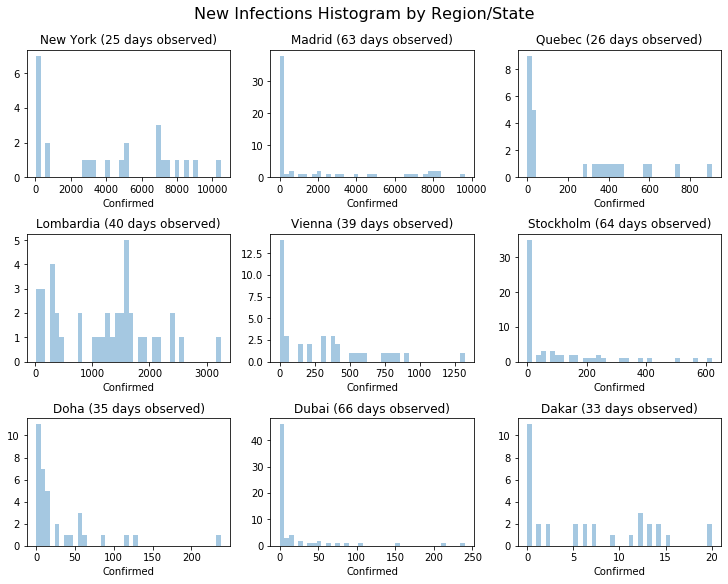

In [36]:
from functions import trim_axs, color_p_value
# Histogram of the new cases by cities
fig1, axs = plt.subplots(3, 3, figsize=(10,8), constrained_layout=True)
axs = trim_axs(axs, len(cities))
for ax, city in zip(axs, cities):
    X=covid_weather.loc[covid_weather['Province/State']==city,'Confirmed']
    ax.set_title('{} ({} days observed)'.format(city,len(X)))
    sns.distplot(X,kde=False,ax=ax,bins=40)
fig1.suptitle('New Infections Histogram by Province/State', fontsize=16);

For these tests, I am going to set the critical value $\alpha=0.05$, and establish the length of each sample to the lengh of the sample with less observations. This is, if X, Y are the two samples to compare with length $l_X$ and $l_Y$ respectively, and $\hat{l}=min(l_X,l_Y)$, then I am only going to consider the observations of X and Y between the first infection day and the day $\hat{l}$.
> The above could look tricky, but in fact, it has an easy explanation, and it is that we need to compare the same number of days after the first infection because in the other way we are introducing a bias based on the lack of information in the distribution with fewer observations.

In [169]:
## t-student Hypothesis tests ##
from functions import t_test_byCities
# Create a dictionary with the pairs of cities to be tested
cities2test=dict({'Dakar': ['New York','Madrid','Lombardia','Vienna','Stockholm','Quebec'],
                 'Doha': ['New York','Madrid','Lombardia','Vienna','Stockholm','Quebec'],
                 'Dubai': ['New York','Lombardia','Stockholm','Quebec']})
# Run the tests (use the function "t_test_byCities" available in "functions.py") 
results_pvalue, results_stat=t_test_byCities(cities2test,covid_weather)

print('The p-values are:')
results_pvalue.style.applymap(color_p_value)

The p-values are:


,Dakar,Doha,Dubai
New York,0.000002,0.000002,0.000002
Madrid,0.436531,0.022827,nan
Lombardia,0.000000,0.000000,0.000000
Vienna,0.000094,0.000084,nan
Stockholm,0.000010,0.000968,0.000020
Quebec,0.000103,0.000241,0.000084


In [170]:
print('The t-statistics are:')
results_stat.style.applymap(color_p_value)

The t-statistics are:


,Dakar,Doha,Dubai
New York,-5.943571,-5.918679,-5.948893
Madrid,-0.160715,2.046333,nan
Lombardia,-7.355718,-7.739180,-9.187024
Vienna,-4.220422,-4.207179,nan
Stockholm,4.894843,3.337723,-4.390181
Quebec,-4.340313,-3.977127,-4.418207


The  results obtained through the `stats.ttest_ind` function are relatives to a [two-tailed test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html), and for that reason, I divided the p-value by 2 (one-tailed test), and print the t-statistic. 
* If $p/2<0.05$ and $t>0$ then we are on the right tail of the distribution and we can affirm that the mean of new cases in warm regions is greater than in other regions, 
* If $p/2<0.05$ and $t<0$ we can conclude that the mean of new cases is lesser when the temperature is upper $60^o F$.

In 12 of the 16 hypothesis tests, we reject the null hypothesis in favor of the alternative (the mean of the people infected in regions with temperatures under $60^o F$ is more than regions with temperatures over $60^o F$). Nevertheless, it may be interesting to study what happened in these 4 cases where we fail to reject the null hypothesis. In my opinion, a nice way to see this is to relate the number of new infections by day. Fig. _"New Infections and Average Temperature by Day (Madrid, Dakar, Doha)"_ shows this relationship in the case of Madrid, Dakar and Doha (note that we fail to reject the null hyphotesis in the test between "Madrid vs Doha" and "Madrid vs Dakar"), and is easy to see an interesting patter here:
1. We have only $\approx 32$ days in common between the three distributions (number of days since the first infection).
2. Madrid and Dakar have almost the same number of infections by day until day 32, while some days Doha seems to have more infections than Madrid, which explains why we fail to reject the null hypothesis in these case, but this isn't all:
    1. After day 32, the number of cases increases exponentially in Madrid, but we don't have more information about Doha or Dakar because at this moment these regions only had one month since the first infection.  
    2. The temperature in Madrid doesn't suffer big changes after day 32 (see Fig. _"New Infections and Average Temperature by Day"_), so, this doesn't seem to be the factor that shot the number of infections.
    > At this point we can formulate two hypothesis:
        1. The spread of the virus in Doha and Dakar is following a pattern very similar to the case of Madrid, and in the following days, we are going to see an exponential increase in the number of new infections in these regions (I don't believe that this is the case if we also consider that the number of new infections in Dubai is stable and close to zero).
        2. Other factors (like socioculturals) make a huge impact in the spread of the virus. This looks like a more reasonable hypothesis, but we are not going deeper here because this topic is beyond the scope of this project.

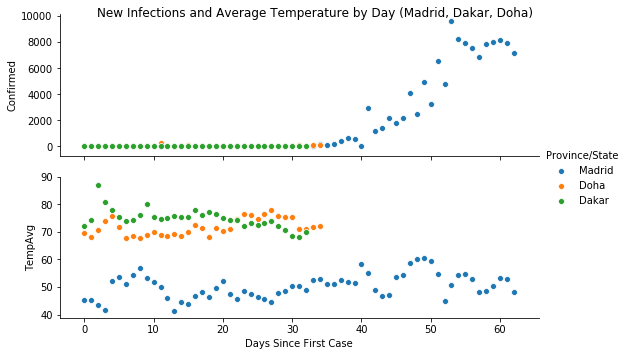

In [171]:
# Extract only the information of Dakar, Doha, and Madrid
Dakar_Doha_Madrid=covid_weather.loc[covid_weather['Province/State'].isin(['Doha','Dakar','Madrid']),:]
# Plot the number of new cases and temperature for Madrid, Dakar and Doha
g=sns.pairplot(x_vars="Days Since First Case", aspect=3,
             y_vars=["Confirmed","TempAvg"], kind='scatter', hue="Province/State",
             data=Dakar_Doha_Madrid);
g.fig.suptitle("New Infections and Average Temperature by Day (Madrid, Dakar, Doha)");    

The same situation occurs in the case of Stockholm, Dakar, and Doha. You can see in Fig. _"New Infections and Average Temperature by Day (Stockholm, Dakar, Doha)"_ that the number of cases increases exponentially in Stockholm after the first 35 days of the first infection. The conclusions explained before in the case of Madrid are extensible to this case, and we need to wait for more information to draw conclusions in these four regions comparison.

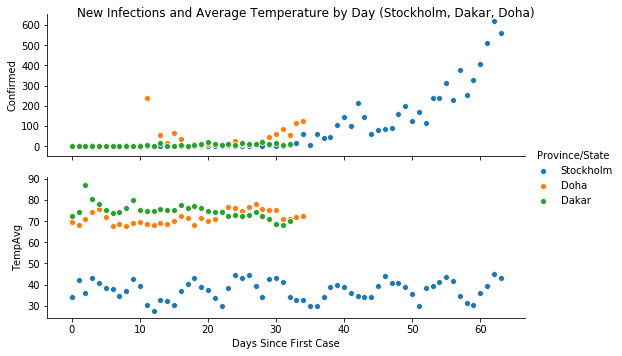

In [172]:
Dakar_Doha_Stockholm=covid_weather.loc[covid_weather['Province/State'].isin(['Doha','Dakar','Stockholm']),:]
# Plot the number of new cases and temperature in Stockholm, Dakar and Doha
g=sns.pairplot(x_vars="Days Since First Case", aspect=3,
             y_vars=["Confirmed","TempAvg"], kind='scatter', hue="Province/State",
             data=Dakar_Doha_Stockholm);
g.fig.suptitle("New Infections and Average Temperature by Day (Stockholm, Dakar, Doha)");  

Finally, below I include an interactive graphic as a tool if somebody wants to play with this data. If you can find some patterns that I didn't perceive, please, let me know about it.

In [173]:
# Plot the number of new infections by day and region
px.scatter(covid_weather, x="Days Since First Case",y="Confirmed",color="Province/State",
          title='New Infections by Day')

### Coronavirus vs Humidity
<a id='coronavirus_vs_humidity'></a>

So far, we know that high temperatures potentially reduce the spread of the coronavirus, but what about other weather factors like humidity or pressure? In this section, I am going to see if exists any kind of relationship between the humidity and the spread of the virus.     
The next table resumes the minimum and maximum values of the average humidity by `Province/State`. The range of values is wide in each of the cases, being New York the State with less reported humidity.    

In [174]:
# Min and Max Humidity Average values by Province/State
covid_weather.pivot_table(index="Province/State",values="HumAvg", aggfunc=['min','max'])

,min,max
,HumAvg,HumAvg
Province/State,,
Dakar,34.7,86.5
Doha,36.7,88.1
Dubai,28.0,73.8
Lombardia,30.5,96.7
Madrid,47.3,95.4
New York,25.8,80.8
Quebec,48.9,94.3
Stockholm,34.2,97.9


Fig. _"Number of New Infections by Day and Humidity Average"_ shows the number of new infections in relationship with the days since the first infection and the humidity average by day. If we interact with the graphic, it's possible to observe than don't exists (at least with the naked eye) a clear relationship between the humidity and the new infections (low or high humidity doesn't imply a high or a low number of infections and vice versa in each `Province/State`).       
> Nevertheless, would be interesting to see if exists differences in the humidity between regions and in such cases if that difference seems to have an impact on the number of cases.

In [175]:
# PLot the number of infections in relationship with the Days since the first infection and the Humidity Avg
px.scatter(covid_weather, x="Days Since First Case", 
           y="Confirmed", size="HumAvg",color="Province/State",
          title="Number of New Infections by Day and Humidity Average")

Again, if we want to compare the number of cases between regions it's necessary to consider the same number of days since the first infection. The  table below shows that the maximum number of days that we can consider is 25 (New York). 

In [176]:
# Number of cases by Province/State
covid_weather.pivot_table(index="Province/State",values='HumAvg',aggfunc='count')

,HumAvg
Province/State,
Dakar,33
Doha,35
Dubai,66
Lombardia,40
Madrid,63
New York,25
Quebec,26
Stockholm,64
Vienna,39


The next chunk of code transforms or data frame and now we only include the first 25 observations by region. Just to be sure that everything looks as was planned, I printed the minimum and maximum day after the first case by Province/State.

In [45]:
# Reduce each group to only the first 25 observations
reduced_data=covid_weather.loc[(covid_weather['Days Since First Case']>=0) & 
                 (covid_weather['Days Since First Case']<=24),:]
reduced_data.pivot_table(index='Province/State',values='Days Since First Case',aggfunc=['min','max'])

,min,max
,Days Since First Case,Days Since First Case
Province/State,,
Dakar,0,24
Doha,0,24
Dubai,0,24
Lombardia,0,24
Madrid,0,24
New York,0,24
Quebec,0,24
Stockholm,0,24


The faster way to prove the existence of differences in the distribution of the `HumAvg` between regions (`Province/State`) is to use an analysis of variance ([ANOVA](https://en.wikipedia.org/wiki/Analysis_of_variance)). One of the key assumptions of this test is the homogeneity of the variance ([homoscedasticity](https://en.wikipedia.org/wiki/Homoscedasticity)), and a good way to prove this is using the [Levene's Tests](https://en.wikipedia.org/wiki/Levene%27s_test). Under the null hypothesis, this test assumes the equality of the variance while the alternative hypothesis is that the variance are different. Again, I am going to use a critical value $\alpha=0.05$.

In [177]:
# Create a list of 1-D arrays with the information of the Average Humidity.  
data = [reduced_data.loc[ids, 'HumAvg'].values for ids in 
        reduced_data.groupby('Province/State').groups.values()]

In [178]:
# Run the Levene's test for the homeostasis of the variance
from scipy import stats
print(stats.levene(*data))

LeveneResult(statistic=7.524914343656738, pvalue=7.474531583844797e-09)


The p-value is smaller than 0.05, so we reject the null hypothesis ==> There are differences in the variance between groups ==> We can\'t use ANOVA. The alternative is to use a [Kruskal-Wallis H hypothesis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance), which is the non-parametric version of ANOVA.

In [179]:
# Kruskal-Wallis H hypothesis test (analysis of the variance)
stats.kruskal(*data)

KruskalResult(statistic=107.55533795280314, pvalue=1.2099119778068317e-19)

The p-value is in the order of $10^{-19}$ ==> Reject the null hypothesis that the population medians of all of the groups are equal, and as consequence, exist differences in the humidity between cities. Now, we need to do a post hoc test to see which groups are different. For this, I am going to use [Dunn's tests](https://www.tandfonline.com/doi/abs/10.1080/00401706.1964.10490181) as a post hoc with a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) of the p-value, and this is justified because:
* Dunn's test employs the same ranking than the Kruskal-Wallis test.
* Dunn's test employs the pooled variance implied by the null hypothesis of the Kruskal-Wallis test. See [here](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance#cite_note-Dunn-5) for more information.    
Note that the Bonferroni correction is necessary because we are doing multiple comparisons between groups.

In [181]:
# Use the library scikit_posthocs to the posthoc test
import scikit_posthocs as sp
result=sp.posthoc_dunn(reduced_data,val_col='HumAvg',p_adjust='bonferroni',group_col='Province/State')

The next heatmap shows the results of the post hoc test, and if we take into account our previous study about the differences between the number of new infections, we can infer that the humidity doesn't have any influence on the spread of the virus. For example, in the first 25 days of infection, New York had 195 times more cases than Doha and 7922 times that Dubai, but our test revealed that don't exist statistical differences between the humidity of these regions. On the other hand, there is a significant difference between the humidity in Madrid and Dakar but as we analyzed in the previous section, there are no differences between the distribution of the new infections of these two regions.   
> Based on these results, I think that the humidity is not an influencing environmental factor in the spread of the virus.

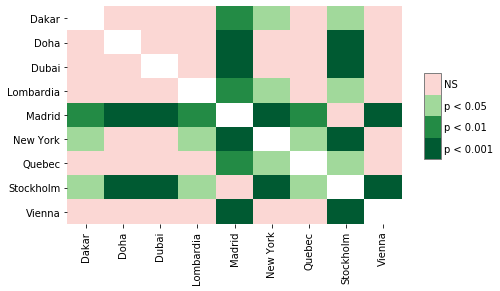

In [50]:
# Plot the results as a heatmap
sp.sign_plot(result);

### Coronavirus vs Pressure
<a id='coronavirus_vs_pressure'></a>

According to [Gay-Lussac's law](https://en.wikipedia.org/wiki/Gay-Lussac%27s_law) the pressure and the temperatures are directly proportional to each other, so, if the temperature increase, the pressure increase, and vice-versa. Some good examples and explanations are available [here](https://www.enotes.com/homework-help/what-relationship-between-air-temperature-air-162931).
> "An easy way to understand this concept is by comparing car tires in the winter and car tires in the summer. In the summer the air is a lot warmer so the molecules are moving around a lot. The tire expands and you not need as much air because the pressure in the tires is high enough. In the winter, when the air is cold, the molecules are moving very slowly. Many people need to add more air to their tires because there is not enough pressure."    

So, if these two variables are correlated and we analyzed the temperature, there is no reason to analyze the pressure, right? Maybe, but no soo fast! There is another atmospheric relationship that we don't talk yet and it is that the [pressure drops as altitude increases](https://www.nationalgeographic.org/encyclopedia/atmospheric-pressure/), and as the pressure decrease the amount of oxygen also decreases. Now, do you think that it's valid to study the relationship between the altitude of the province or states as a factor in the spread of the virus? It seems unlikely that this could be a key factor but at least we can get out of the doubt.

The altitude in feet and meters of our 9 `Province/State` are included in the next table.

| Province/State | Altitude     |
|----------------|--------------|
| New York       | 33' (10m)    |
| Madrid         | 2188' (667m) |
| Doha           | 33' (10m)    |
| Dakar          | 72' (22m)    |
| Dubai          | 52' (16m)    |
| Lombardia      | 390' (120m)  |
| Quebec         | 322' (98m)   |
| Stockholm      | 62' (19m)    |
| Vienna         | 2273' (350m) |

The region with more altitude is Madrid followed by Vienna and Lombardia,  while New York, Doha, and Dubai have very close altitudes. The case of Madrid is interesting because we know that this city is one of the three with more cases worldwide. Fig. _"Boxplot Pressure by Province/Stats"_ shows that as was expected, Madrid has a significantly lower pressure than the other regions. So, if the pressure given the altitude is a factor in the spread of the virus, we should expect that the number of infections in Madrid will be greater (lower) than each of the other regions.

In [182]:
# Boxplot of the pressure by Province/State
px.box(covid_weather, x='Province/State', y='Pressure_Avg',
       title='Boxplot Pressure by Province/State')

The previous idea seems valid, but in fact, we need to take the temperature out of the equation if we want to be sure that if exist differences is because the altitude/pressure and not for the temperature (which we are pretty sure that have an influence in the spread of the virus). With this aim, the simpler solution is to include in the study only the `Province/Regions` with temperatures that are not significantly different than Madrid. As we did in Section [Coronavirus vs Humidity](#coronavirus_vs_humidity), we are going to analyze all the cities at the same time through a variance analysis. 

In [52]:
# Create a list of 1-D arrays with the information of the Average Humidity.  
data = [reduced_data.loc[ids, 'TempAvg'].values for ids in 
        reduced_data.groupby('Province/State').groups.values()]
# Levene's test
print(stats.levene(*data))
print('The test reveals that there are statistically significant differences between the variance of the temperature in different cities.')

LeveneResult(statistic=4.217025207829537, pvalue=0.00010215607663407147)
The test reveals that there are statistically significant differences between the variance of the temperature in different cities.


In [53]:
# Kruskal-Wallis H hypothesis test (analysis of the variance)
print(stats.kruskal(*data))
print('The Kruskal-Wallis test shows that there are differences in the distribution of the temperature across different Province/State.')

KruskalResult(statistic=197.93719460751058, pvalue=1.738021217309792e-38)
The Kruskal-Wallis test shows that there are differences in the distribution of the temperature across different Province/State.


The below heatmap shows the result of the post hoc Dunn's test with Bonferroni correction. In the case of Madrid, we fail to reject the null hypothesis of equality of the median of the temperatures in the combinations with New York, Lombardia, and Vienna, so now we can take these two by two combinations {(Madrid-New York), (Madrid-Lombardia), (Madrid-Vienna)} and see if existing differences in the number of new infections.

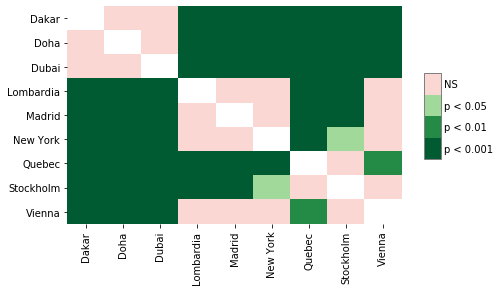

In [183]:
# Dunn Posthoc test with Bonferroni correction 
result=sp.posthoc_dunn(covid_weather,val_col='TempAvg',p_adjust='bonferroni',group_col='Province/State')
sp.sign_plot(result);

At this point, the objective is to see if exists differences in the number of infections in each of the three pair of cities defined before. Based on the same explanation given in Section [Coronavirus vs Temperature](#coronavirus_vs_temperature), we are going to use a one tail t-student test with critical value $\alpha=0.05$. Again, the null hypothesis is that there aren't differences in the mean of the number of new infections between the cities and the alternative is that there is.    
The results (see data frame below) are extremely interesting! Note that in all the comparisons we obtained that the number of new infections in Madrid is significantly lower (from a statistical point of view) than in all the other regions with similar temperatures. Also, the population density in Madrid is greater than the other three regions, so, this doesn't seem to be the factor that explains this difference.    
What do you think about this? Is it not weird? I think it is, and this is because currently, we know that Madrid is one of the three regions with more cases, so, what happened here?     
* This effect is given because (as we did before) we are only considering the common maximum number of days since the first infection between both cities. Remember that I made this decision as a way to mitigate the effect that cities with a greater number of days are more likely to have more cases.
* If we observe the relationship of the number of new cases by city and the number of days since the first infection (Fig. _"New Infections by Day (Madrid, New York, Lombardia, Vienna)"_ below), it is easy to see that our dataset only have the information of Vienna and Lombardia in approximately 40 days, and in those first 40 days, Madrid has fewer infections than these two regions and New York, so, this is the reason why we are obtaining significant statistical differences.
* Now, the number of cases increased exponentially in Madrid after  40 days of infection, so, maybe these differences in the first 40 days are just a random effect and are not related with the altitude, or the altitude has an effect in the spread of the virus, but a new factor took effect in Madrid after the 40 first days and mitigated the effect of the altitude.    
> At this point, this analysis is something interesting but is far away to be conclusive! A lot more data and analysis are necessary if we want to prove this hypothesis.

In [184]:
# Create a dictionary with the combinations of cities
cities2test=dict({'Madrid': ['New York','Lombardia','Vienna']})
# Run the tests
results_pvalue, results_stat=t_test_byCities(cities2test,covid_weather)
results_pvalue['t-stats']=results_stat['Madrid']
results_pvalue=results_pvalue.rename(columns={'Madrid':'p-value'})
results_pvalue

,p-value,t-stats
Lombardia,4.320449e-11,-8.619533
New York,1.930117e-06,-5.949297
Vienna,2.118015e-05,-4.506821


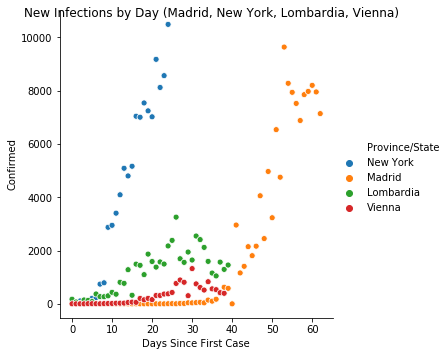

In [185]:
# Plot the number of cases by day only for Madrid, Lombardia, New York and Vienna.
g=sns.relplot(x='Days Since First Case',y='Confirmed',hue='Province/State',
            data=covid_weather.loc[covid_weather['Province/State'].isin(['Madrid',
                                                                         'New York','Lombardia',
                                                                         'Vienna']),:]);
g.fig.suptitle("New Infections by Day (Madrid, New York, Lombardia, Vienna)");

## Conclusions and Remarks
<a id='conclusions_and_remarks'></a>
1. Temperatures over the $60^o F$ seems to affect the spread of the virus.
2. The humidity doesn't seem to be an environmental factor that affects the spread of the virus.
3. Our data shows that in the case of Madrid, the pressure given the altitude had a negative effect on the spread of the virus (reduced the spread) in the first 40 days of infection, but these results are not conclusive and we need a lot of more data to have a better idea of this effect.

### Remarks
* In my opinion, the study of only 9 cities (even when the cities were selected with a logical criterion) is not enough to draw valid conclusions about general climatological conditions that affect or not the spread of the virus independently of the city or region. 
* There are a lot of factors, like the sociocultural ones, that have a strong incidence in the spread of the virus independently of the weather. Assuming (like I did) that these factors are going to be similar between different regions is a long shot, but it is the only way at this moment to contrast different weather conditions with the number of new infections.
* In this project, we only developed a univariate statistical analysis about the influence of 3 weather variables with the number of new infections, but a multivariate analysis would be great to elucidate more complex relationships between the weather and the spread of the virus.

In general, a lot of work remains to do, and more data it's necessary if we want to provide accurate answers. All the codes and datasets employed in this project are available [here](https://github.com/Yasel-Garces/The-impact-of-weather-in-the-coronavirus-spread), and if you have or know where to find more open/free weather data to improve this analysis, please let me know. 

> Meanwhile, would be great to know what you think about the impact of the weather in the spread of the coronavirus or your opinion about the questions that remain open in this work.

**Thanks for reading and keep safe!!**